In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

In [2]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = train[categorical_fs]
others = train[other_fs[1:-1]]

new_categoricals = ps.fuseCategoricalFeatures(categoricals)

bincats = pd.concat([binaries, new_categoricals], axis=1)
target = train.target

In [3]:
others.shape

(595212, 26)

### Select already digitized features

In [6]:
ordinal_fs = ['ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 
              'ps_calc_13', 'ps_calc_14', 'ps_car_11', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 
              'ps_ind_15', 'ps_reg_01', 'ps_reg_02']
ordinals = others[ordinal_fs]
ordinals.shape

(595212, 15)

In [15]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [16]:
ordinals_fused = ps.fuseCategoricalFeatures(ordinals, dictionary='ordinal')

In [19]:
ordinals_fused.head(5)

,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_reg_01,ps_reg_02
0,0,2,0,1,4,0,0,1,2,0,2,0,2,2.0,1.0
1,0,2,0,1,2,0,0,1,3,0,2,0,1,2.0,1.0
2,0,2,0,1,2,0,0,1,0,1,3,0,2,0.0,0.0
3,0,2,0,1,2,0,0,1,0,0,1,0,2,3.0,1.0
4,0,2,0,1,2,0,0,1,3,0,0,0,2,2.0,2.0


In [18]:
for i, f in enumerate(ordinals_fused.columns):
    fvt = fa.FeatureVsTarget(ordinals_fused[f], target)
    print('==== %s ====' % f)
    print(fvt.contingency_table_)
    print(fvt.conditional_probas_)
    print(100*(fvt.calculate_deviation(mode='ratio')[0] - 1))
    print('\n')

==== ps_calc_05 ====
target           0      1
ps_calc_05               
0           572990  21664
1              528     30
target             0         1
ps_calc_05                    
0           0.963569  0.036431
1           0.946237  0.053763
target             0          1
ps_calc_05                     
0           0.001686  -0.044581
1          -1.797092  47.509197


==== ps_calc_06 ====
target           0      1
ps_calc_06               
0             1297     41
1             6448    257
2           565773  21396
target         0         1
0       0.969357  0.030643
1       0.961670  0.038330
2       0.963561  0.036439
target         0          1
0       0.602434 -15.926373
1      -0.195328   5.163827
2       0.000858  -0.022675


==== ps_calc_07 ====
target           0      1
ps_calc_07               
0           549139  20719
1            24379    975
target             0         1
ps_calc_07                    
0           0.963642  0.036358
1           0.961545  0.038455

### Convert into ratios and PCA

In [27]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()
    bincat_converted[f] = bincats[f].replace(bincat2probas)

In [28]:
ordinals_converted = pd.DataFrame()
for i, f in enumerate(ordinals_fused.columns):
    fvt = fa.FeatureVsTarget(ordinals_fused[f], target)
    ordinal2probas = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()
    ordinals_converted[f] = ordinals_fused[f].replace(bincat2probas)

In [33]:
converted = pd.concat([bincat_converted, ordinals_converted], axis=1)

In [34]:
pca = PCA()
X = np.array(converted)
y = train.target

Xpca = pca.fit_transform(X)

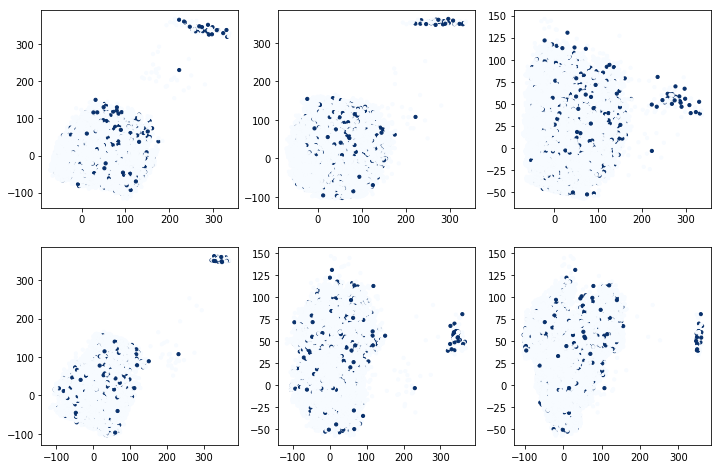

In [35]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap=cm.Blues, s=10)
ax2.scatter(Xpca[:, 0], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax3.scatter(Xpca[:, 0], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax4.scatter(Xpca[:, 1], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax5.scatter(Xpca[:, 1], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax6.scatter(Xpca[:, 2], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)

In [36]:
pca.explained_variance_ratio_

array([  1.48500771e-01,   7.99104491e-02,   7.77474536e-02,
         6.63637601e-02,   6.13908320e-02,   5.95554180e-02,
         5.64510978e-02,   5.48067678e-02,   4.82880933e-02,
         3.80905933e-02,   3.58416441e-02,   3.35655134e-02,
         3.00584527e-02,   2.84068622e-02,   2.52769109e-02,
         2.33966618e-02,   2.24997638e-02,   1.88112211e-02,
         1.64703209e-02,   1.40507223e-02,   1.24163473e-02,
         1.09060441e-02,   8.31993042e-03,   7.55032101e-03,
         5.45641667e-03,   4.28143872e-03,   3.20164220e-03,
         2.71806734e-03,   1.84607282e-03,   1.45334850e-03,
         1.19320159e-03,   2.41786779e-04,   2.23277409e-04,
         2.06759558e-04,   1.28422658e-04,   1.07903020e-04,
         1.00512083e-04,   7.35281814e-05,   3.58430849e-05,
         2.39691763e-05,   1.28638721e-05,   1.00878683e-05,
         7.95027204e-06,   9.56734761e-07,   9.02385023e-28])

<Container object of 45 artists>

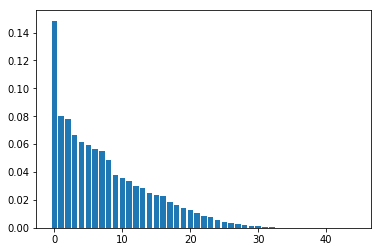

In [37]:
plt.bar(range(Xpca.shape[1]), pca.explained_variance_ratio_)

In [39]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

Gini=0.242+/-0.013, Best=0.265
CPU times: user 9min 7s, sys: 858 ms, total: 9min 8s
Wall time: 1min 15s


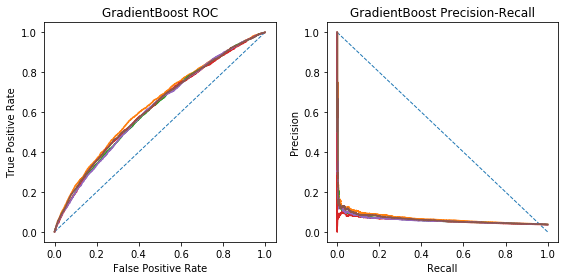

In [40]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca[:, :30], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [41]:
clf.feature_importances_

array([ 0.15063451,  0.04567727,  0.03873889,  0.03205459,  0.02393332,
        0.02459636,  0.04836168,  0.04605691,  0.02780964,  0.03675233,
        0.02603764,  0.02335268,  0.02236242,  0.02076188,  0.02763605,
        0.0224031 ,  0.02477129,  0.02214838,  0.02348859,  0.02132351,
        0.0224255 ,  0.02278774,  0.02459123,  0.0322672 ,  0.02664117,
        0.02735186,  0.02502442,  0.04963066,  0.02502774,  0.03535141])